<a href="https://colab.research.google.com/github/Ermakov764/Multitasker/blob/main/Multitasker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Установка библиотек
!pip install -q gensim nltk transformers datasets accelerate evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00


In [2]:
# Установка библиотек
!pip install -q gensim nltk transformers datasets accelerate evaluate scikit-learn

In [3]:
# Импорты
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Настройки визуализации
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
# Загрузка основного датасета
df = pd.read_csv("hf://datasets/Console-AI/IT-helpdesk-synthetic-tickets/tickets.csv")

# Загрузка дополнительных данных (если есть)
try:
    df_dop = pd.read_csv('/content/balanced_low_urgent.csv')
    # Распределение категорий из основного датасета
    category_probs = df['category'].value_counts(normalize=True)
    # Присваиваем категории пропорционально
    np.random.seed(42)
    df_dop['category'] = np.random.choice(
        category_probs.index,
        size=len(df_dop),
        p=category_probs.values
    )
    df = pd.concat([df, df_dop], ignore_index=True)
    print(f"Загружено {len(df)} записей после объединения")
except FileNotFoundError:
    print(f"Загружено {len(df)} записей (дополнительный файл не найден)")

# Проверка распределения приоритетов
print("\n Распределение приоритетов (4 класса):")
print(df['priority'].value_counts().sort_index())

# Базовая информация о данных
print("\n Информация о датасете:")
print(f"Всего записей: {len(df)}")
print(f"Пропущенных значений: {df.isna().sum().sum()}")
print(f"Дубликатов: {df.duplicated().sum()}")

Загружено 700 записей после объединения

 Распределение приоритетов (4 класса):
priority
High      199
Low       104
Medium    293
Urgent    104
Name: count, dtype: int64

 Информация о датасете:
Всего записей: 700
Пропущенных значений: 0
Дубликатов: 0


In [5]:
df.head()

,id,subject,description,priority,category,createdAt,requesterEmail
0,1aiu3lrqi,Hey IT! Our network printer keeps disconnecting.,Hey IT! Our network printer keeps disconnectin...,Medium,Network,2024-10-28T18:36:55.004Z,jane.doe@acme.co
1,kz5mjjpox,Re: [Acme IT] Re: Ticket #98765 - Access Issue...,This is a follow-up to your previous request #...,High,Network,2024-10-28T18:36:56.156Z,user123@acme.co
2,86eza0fwq,Software Conflict Causing App Crashes,Hey team! :wave: We're experiencing some inter...,High,Software,2024-10-28T18:36:54.644Z,user@acme.co
3,jtw509e3n,j.doe@acme.co Google Calendar Setup Assistance,We need to set up a new Google Calendar for te...,Medium,Software,2024-10-28T18:36:54.524Z,j.doe@acme.co
4,tso616mbn,Software Access: Asana Project for Jordan Smith,Jordan Smith is part of the Project Management...,Medium,Software,2024-10-28T18:36:54.816Z,jordan.smith@acme.co


# ОБЩИЕ ФУНКЦИИ ДЛЯ ВСЕХ МОДЕЛЕЙ

In [6]:
def extract_urgency_signals(text):
    """Извлекает 3 сигнала срочности из текста"""
    text_lower = text.lower()
    words = text.split()

    # Сигнал 1: Доля слов заглавными буквами (≥3 буквы)
    caps_ratio = sum(1 for w in words if w.isupper() and len(w) >= 3) / max(len(words), 1)

    # Сигнал 2: Скор срочности на основе ключевых маркеров
    urgency_score = 0.0
    if re.search(r'\burgent\b', text_lower): urgency_score += 2.0
    if re.search(r'\bcritical\b', text_lower): urgency_score += 1.8
    if re.search(r'\bimmediately\b', text_lower): urgency_score += 1.5
    if re.search(r'\basap\b', text_lower): urgency_score += 1.2
    if re.search(r'\bdown\b', text_lower) and ('server' in text_lower or 'system' in text_lower):
        urgency_score += 1.5
    if re.search(r'\bfailure\b', text_lower): urgency_score += 1.0
    if re.search(r'\bemergency\b', text_lower): urgency_score += 2.0

    # Сигнал 3: Отношение длины заголовка к описанию
    parts = text.split(':', 1)
    title_ratio = 0.0
    if len(parts) > 1 and len(parts[1].strip()) > 0:
        title_words = len(parts[0].split())
        desc_words = len(parts[1].split())
        title_ratio = title_words / (desc_words + 1)

    return {
        'caps_ratio': min(caps_ratio, 1.0),
        'urgency_score': min(urgency_score, 5.0) / 5.0,
        'title_ratio': min(title_ratio, 1.0)
    }

In [7]:
def prepare_features(df):
    """
    Подготавливает признаки для всех моделей (кроме DistilBERT)
    Возвращает: X (матрица признаков), vectorizer, signals_df
    """
    # Создаём единый текстовый столбец
    df['text'] = df['subject'].fillna('') + ' ' + df['description'].fillna('')

    # Извлекаем сигналы срочности
    signals_df = pd.DataFrame([extract_urgency_signals(t) for t in df['text']])

    # Кастомные стоп-слова
    custom_stop_words = list(ENGLISH_STOP_WORDS) + [
        'hello', 'hi', 'hey', 'thanks', 'thank', 'please', 'kindly',
        'regards', 'best', 'sincerely', 'team', 'support', 'dear', 'user',
        'issue', 'problem', 'help', 'assistance', 'regarding', 'regard'
    ]

    # TF-IDF векторизация
    vectorizer = TfidfVectorizer(
        max_features=1000,
        min_df=3,
        max_df=0.85,
        ngram_range=(1, 2),
        stop_words=custom_stop_words,
        sublinear_tf=True
    )

    X_tfidf = vectorizer.fit_transform(df['text'])

    # Объединяем TF-IDF + сигналы срочности
    X = hstack([X_tfidf, signals_df.values])

    print(f"Признаки подготовлены:")
    print(f"   - TF-IDF: {X_tfidf.shape[1]} признаков")
    print(f"   - Сигналы срочности: {signals_df.shape[1]} признаков")
    print(f"   - Итого: {X.shape[1]} признаков")

    return X, vectorizer, signals_df

In [8]:
def compute_class_weights(df):
    """Вычисляет веса классов для балансировки"""
    class_counts = df['priority'].value_counts()
    total = len(df)
    base_weight = total / (len(class_counts) * class_counts)

    manual_weights = {
        'Low': base_weight['Low'] * 1.0,
        'Medium': base_weight['Medium'] * 1.0,
        'High': base_weight['High'] * 1.2,
        'Urgent': base_weight['Urgent'] * 1.8
    }

    return manual_weights

In [9]:
# Подготовка признаков (выполняется один раз для всех моделей)
X, vectorizer, signals_df = prepare_features(df)
y = df['priority']  # Работаем напрямую с текстовыми метками

# Вычисляем веса классов
class_weights = compute_class_weights(df)

print("\n Веса классов:")
for cls, weight in class_weights.items():
    print(f"   {cls:8s}: {weight:.3f}")

# Разделяем данные на train/test (используется всеми моделями)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n Данные разделены:")
print(f"   - Обучающая выборка: {X_train.shape[0]} записей")
print(f"   - Тестовая выборка: {X_test.shape[0]} записей")

Признаки подготовлены:
   - TF-IDF: 1000 признаков
   - Сигналы срочности: 3 признаков
   - Итого: 1003 признаков

 Веса классов:
   Low     : 1.683
   Medium  : 0.597
   High    : 1.055
   Urgent  : 3.029

 Данные разделены:
   - Обучающая выборка: 560 записей
   - Тестовая выборка: 140 записей


# ОБЩИЕ ФУНКЦИИ ДЛЯ ОЦЕНКИ МОДЕЛЕЙ

In [10]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Полная оценка модели с визуализацией"""
    y_pred = model.predict(X_test)

    # Основные метрики
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("\n" + "="*70)
    print(f"РЕЗУЛЬТАТЫ: {model_name}")
    print("="*70)
    print(f"Accuracy: {acc:.4f}")
    print(f"Weighted F1-score: {f1:.4f}")

    # Детальный отчёт
    print("\nДетальный отчёт по классам:")
    print(classification_report(y_test, y_pred, digits=3))

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High', 'Urgent'])

    # Визуализация
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High', 'Urgent'],
                yticklabels=['Low', 'Medium', 'High', 'Urgent'])
    plt.xlabel('Предсказано')
    plt.ylabel('Фактически')
    plt.title(f'Матрица ошибок: {model_name}')
    plt.tight_layout()
    plt.show()

    # Бинарная оценка (срочные vs несрочные)
    y_test_binary = y_test.isin(['High', 'Urgent']).astype(int)
    y_pred_binary = pd.Series(y_pred).isin(['High', 'Urgent']).astype(int)

    binary_f1 = f1_score(y_test_binary, y_pred_binary)
    binary_recall = recall_score(y_test_binary, y_pred_binary)

    print("\n Бинарная оценка (Срочные vs Несрочные):")
    print(f"   F1-score: {binary_f1:.4f}")
    print(f"   Recall: {binary_recall:.4f}")

    return {
        'model_name': model_name,
        'accuracy': acc,
        'f1_weighted': f1,
        'f1_binary': binary_f1,
        'recall_binary': binary_recall
    }

In [11]:
def test_urgency_markers(model, vectorizer):
    """Тест на явных маркерах срочности"""
    test_cases = [
        ("URGENT: Production database crashed", "Urgent"),
        ("CRITICAL: Server down affecting all users", "Urgent"),
        ("immediately fix this issue", "High"),
        ("need urgent assistance", "Urgent"),
        ("critical failure in production", "High"),
        ("ASAP required", "High"),
        ("Server down affecting all departments", "High"),
        ("Update my profile picture", "Low"),
        ("Request for new mouse", "Low"),
        ("Question about software license", "Medium")
    ]

    correct = 0
    print("\n Тест на маркерах срочности:")
    for text, expected in test_cases:
        text_vec = vectorizer.transform([text])
        signals = extract_urgency_signals(text)
        signals_vec = np.array([[
            signals['caps_ratio'],
            signals['urgency_score'],
            signals['title_ratio']
        ]])
        X_single = hstack([text_vec, signals_vec])

        pred = model.predict(X_single)[0]
        is_correct = pred == expected
        if is_correct:
            correct += 1
        status = "OK" if is_correct else "WRONG"
        print(f"{status} '{text[:40]:<40}' | Ожидалось: {expected:<7} | Предсказано: {pred}")

    acc = correct / len(test_cases)
    print(f"\n Точность на маркерах: {acc:.1%} ({correct}/{len(test_cases)})")
    return acc

# МОДЕЛЬ 1: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

Fitting 5 folds for each of 8 candidates, totalling 40 fits

 Лучшие параметры: {'C': 0.8, 'class_weight': 'balanced'}
 Лучший F1 на кросс-валидации: 0.8910

РЕЗУЛЬТАТЫ: Логистическая регрессия
Accuracy: 0.8643
Weighted F1-score: 0.8645

Детальный отчёт по классам:
              precision    recall  f1-score   support

        High      0.943     0.825     0.880        40
         Low      0.773     0.810     0.791        21
      Medium      0.864     0.879     0.872        58
      Urgent      0.833     0.952     0.889        21

    accuracy                          0.864       140
   macro avg      0.853     0.867     0.858       140
weighted avg      0.868     0.864     0.865       140



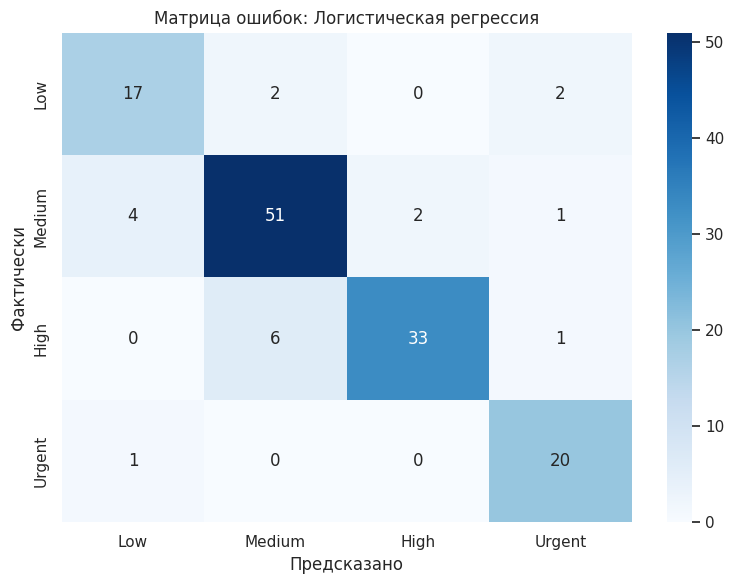


 Бинарная оценка (Срочные vs Несрочные):
   F1-score: 0.9000
   Recall: 0.8852

 Тест на маркерах срочности:
OK 'URGENT: Production database crashed     ' | Ожидалось: Urgent  | Предсказано: Urgent
OK 'CRITICAL: Server down affecting all user' | Ожидалось: Urgent  | Предсказано: Urgent
WRONG 'immediately fix this issue              ' | Ожидалось: High    | Предсказано: Urgent
OK 'need urgent assistance                  ' | Ожидалось: Urgent  | Предсказано: Urgent
WRONG 'critical failure in production          ' | Ожидалось: High    | Предсказано: Urgent
WRONG 'ASAP required                           ' | Ожидалось: High    | Предсказано: Urgent
WRONG 'Server down affecting all departments   ' | Ожидалось: High    | Предсказано: Urgent
OK 'Update my profile picture               ' | Ожидалось: Low     | Предсказано: Low
OK 'Request for new mouse                   ' | Ожидалось: Low     | Предсказано: Low
WRONG 'Question about software license         ' | Ожидалось: Medium  | Предсказано

0.5

In [12]:
# Оптимизация гиперпараметров
param_grid = {
    'C': [0.8, 1.0, 1.5, 2.0],
    'class_weight': ['balanced', class_weights]
}

grid_search = GridSearchCV(
    LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\n Лучшие параметры: {grid_search.best_params_}")
print(f" Лучший F1 на кросс-валидации: {grid_search.best_score_:.4f}")

model_logreg = grid_search.best_estimator_

# Оценка модели
results_logreg = evaluate_model(model_logreg, X_test, y_test, "Логистическая регрессия")

# Тест на маркерах срочности
test_urgency_markers(model_logreg, vectorizer)

# МОДЕЛЬ 2: RANDOM FOREST

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished



РЕЗУЛЬТАТЫ: Random Forest
Accuracy: 0.8786
Weighted F1-score: 0.8797

Детальный отчёт по классам:
              precision    recall  f1-score   support

        High      0.971     0.850     0.907        40
         Low      1.000     0.714     0.833        21
      Medium      0.883     0.914     0.898        58
      Urgent      0.700     1.000     0.824        21

    accuracy                          0.879       140
   macro avg      0.889     0.870     0.865       140
weighted avg      0.899     0.879     0.880       140



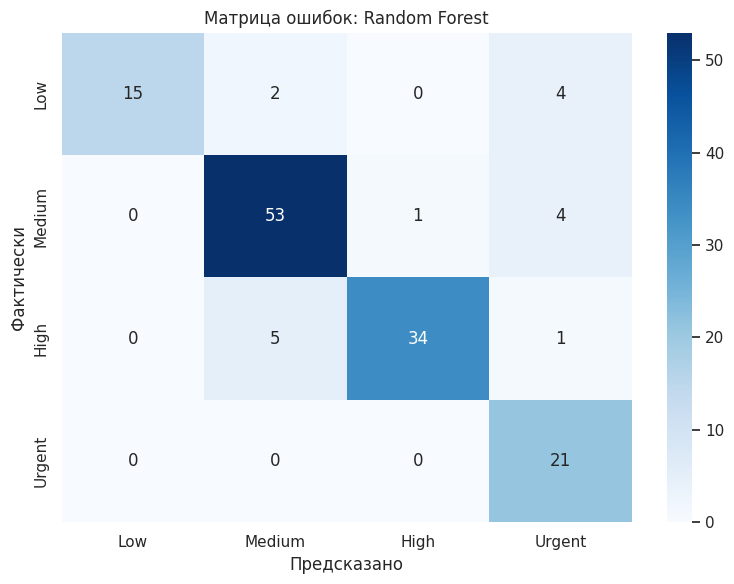


 Бинарная оценка (Срочные vs Несрочные):
   F1-score: 0.8889
   Recall: 0.9180


In [13]:
# Вычисляем веса для Random Forest (они требуют словарь с числовыми ключами)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Преобразуем веса классов
rf_class_weights = {
    le.transform([cls])[0]: weight
    for cls, weight in class_weights.items()
}

model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight=rf_class_weights,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model_rf.fit(X_train, y_train_encoded)

# Декодируем предсказания обратно в текстовые метки
y_pred_rf = le.inverse_transform(model_rf.predict(X_test))

# Создаём "обёртку" для функции evaluate_model
class ModelWrapper:
    def __init__(self, model, label_encoder):
        self.model = model
        self.le = label_encoder

    def predict(self, X):
        return self.le.inverse_transform(self.model.predict(X))

model_rf_wrapped = ModelWrapper(model_rf, le)

# Оценка модели
results_rf = evaluate_model(model_rf_wrapped, X_test, y_test, "Random Forest")

# МОДЕЛЬ 3: GRADIENT BOOSTING

      Iter       Train Loss   Remaining Time 
         1           1.0717           35.32s
         2           0.9213           30.88s
         3           0.7983           27.57s
         4           0.7047           25.73s
         5           0.6270           27.08s
         6           0.5574           26.66s
         7           0.5026           25.75s
         8           0.4545           25.80s
         9           0.4133           26.17s
        10           0.3776           26.80s
        20           0.1699           25.07s
        30           0.0853           24.00s
        40           0.0487           23.20s
        50           0.0293           21.49s
        60           0.0188           18.21s
        70           0.0125           15.90s
        80           0.0086           13.65s
        90           0.0060           11.38s
       100           0.0042            9.36s

РЕЗУЛЬТАТЫ: Gradient Boosting
Accuracy: 0.8857
Weighted F1-score: 0.8856

Детальный отчёт по класс

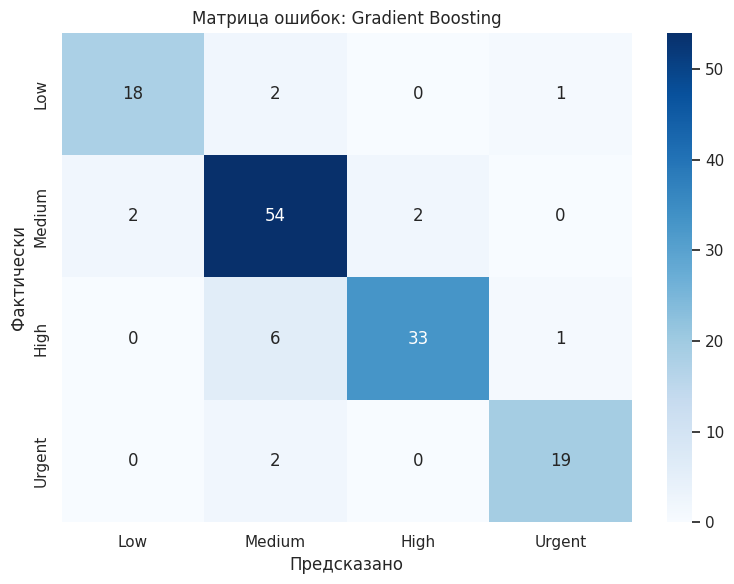


 Бинарная оценка (Срочные vs Несрочные):
   F1-score: 0.9060
   Recall: 0.8689


In [14]:
model_gb = GradientBoostingClassifier(
    n_estimators=150,
    max_depth=7,
    learning_rate=0.1,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    verbose=1
)

model_gb.fit(X_train, y_train_encoded)

model_gb_wrapped = ModelWrapper(model_gb, le)

# Оценка модели
results_gb = evaluate_model(model_gb_wrapped, X_test, y_test, "Gradient Boosting")

# МОДЕЛЬ 4: VOTING ENSEMBLE

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished



РЕЗУЛЬТАТЫ: Voting Ensemble (LR+RF+GB)
Accuracy: 0.9000
Weighted F1-score: 0.8996

Детальный отчёт по классам:
              precision    recall  f1-score   support

        High      0.971     0.825     0.892        40
         Low      0.900     0.857     0.878        21
      Medium      0.859     0.948     0.902        58
      Urgent      0.909     0.952     0.930        21

    accuracy                          0.900       140
   macro avg      0.910     0.896     0.900       140
weighted avg      0.905     0.900     0.900       140



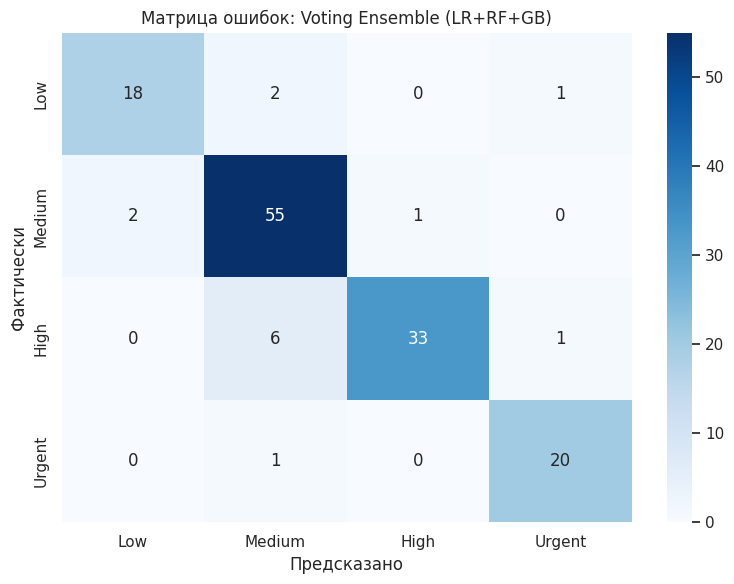


 Бинарная оценка (Срочные vs Несрочные):
   F1-score: 0.9231
   Recall: 0.8852


In [15]:
# Переобучаем логрегрессию на закодированных метках для ансамбля
model_logreg_encoded = LogisticRegression(
    C=grid_search.best_params_['C'],
    class_weight=grid_search.best_params_['class_weight'],
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
model_logreg_encoded.fit(X_train, y_train_encoded)

# Создаём ансамбль
model_ensemble = VotingClassifier(
    estimators=[
        ('lr', model_logreg_encoded),
        ('rf', model_rf),
        ('gb', model_gb)
    ],
    voting='soft',
    n_jobs=-1
)

model_ensemble.fit(X_train, y_train_encoded)

model_ensemble_wrapped = ModelWrapper(model_ensemble, le)

# Оценка модели
results_ensemble = evaluate_model(model_ensemble_wrapped, X_test, y_test, "Voting Ensemble (LR+RF+GB)")

# МОДЕЛЬ 5: DISTILBERT

In [16]:
import torch
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from evaluate import load

In [17]:
# Создаём новый столбец text если его ещё нет
if 'text' not in df.columns:
    df['text'] = df['subject'].fillna('') + ' ' + df['description'].fillna('')

In [18]:
# Кодирование меток
le_bert = LabelEncoder()
df['label'] = le_bert.fit_transform(df['priority'])

print(f"\n Кодирование меток DistilBERT:")
for i, cls in enumerate(le_bert.classes_):
    print(f"   {cls:8s} → {i}")


 Кодирование меток DistilBERT:
   High     → 0
   Low      → 1
   Medium   → 2
   Urgent   → 3


In [19]:
# Разделение данных
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    df['text'], df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

In [20]:
# Создание датасетов
train_dataset = Dataset.from_dict({
    'text': X_train_bert.tolist(),
    'labels': y_train_bert.tolist()
})
test_dataset = Dataset.from_dict({
    'text': X_test_bert.tolist(),
    'labels': y_test_bert.tolist()
})

In [21]:
# Токенизация
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True).remove_columns(['text'])
tokenized_test = test_dataset.map(tokenize_function, batched=True).remove_columns(['text'])
tokenized_train.set_format('torch')
tokenized_test.set_format('torch')

print(" Токенизация завершена")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

 Токенизация завершена


In [22]:
# Загрузка модели
num_labels = len(le_bert.classes_)
model_bert = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label={i: label for i, label in enumerate(le_bert.classes_)},
    label2id={label: i for i, label in enumerate(le_bert.classes_)}
)

print(f" Модель загружена: {model_name}, {num_labels} классов")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


 Модель загружена: distilbert-base-uncased, 4 классов


In [23]:
# Метрики
metric_accuracy = load("accuracy")
metric_f1 = load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = metric_accuracy.compute(predictions=predictions, references=labels)
    f1_weighted = metric_f1.compute(predictions=predictions, references=labels, average='weighted')
    f1_macro = metric_f1.compute(predictions=predictions, references=labels, average='macro')

    return {
        'accuracy': acc['accuracy'],
        'f1_weighted': f1_weighted['f1'],
        'f1_macro': f1_macro['f1']
    }

In [24]:
# Настройки обучения
training_args = TrainingArguments(
    output_dir="./results_distilbert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs_distilbert',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    fp16=torch.cuda.is_available()
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [25]:
# Trainer
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

In [ ]:
print("\n Запуск обучения DistilBERT...")
# Обучение
trainer.train()


 Запуск обучения DistilBERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.675077,0.549334,0.907143,0.907273,0.918605


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Оценка
print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ: DistilBERT")
print("="*70)
metrics = trainer.evaluate()
for key, value in metrics.items():
    if 'eval' in key:
        print(f"{key.replace('eval_', ''):20s}: {value:.4f}")

In [ ]:
# Детальный анализ
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)

y_test_bert_decoded = le_bert.inverse_transform(y_test_bert)
preds_decoded = le_bert.inverse_transform(preds)

print("\nДетальный отчёт по классам:")
print(classification_report(
    y_test_bert_decoded,
    preds_decoded,
    target_names=le_bert.classes_,
    digits=3
))

In [ ]:
# Матрица ошибок
cm = confusion_matrix(y_test_bert_decoded, preds_decoded, labels=le_bert.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_bert.classes_,
            yticklabels=le_bert.classes_)
plt.xlabel('Предсказано')
plt.ylabel('Фактически')
plt.title('Матрица ошибок: DistilBERT')
plt.tight_layout()
plt.show()

In [ ]:
# Сохраняем результаты
results_distilbert = {
    'model_name': 'DistilBERT',
    'accuracy': metrics['eval_accuracy'],
    'f1_weighted': metrics['eval_f1_weighted'],
    'f1_binary': None,  # можно добавить при необходимости
    'recall_binary': None
}

# СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ

In [ ]:
print("\n" + "="*70)
print("ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("="*70)

# Собираем результаты
all_results = [
    results_logreg,
    results_rf,
    results_gb,
    results_ensemble,
    results_distilbert
]

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('f1_weighted', ascending=False)

print("\n Рейтинг по Weighted F1-score:")
print(results_df[['model_name', 'accuracy', 'f1_weighted']].to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Accuracy
axes[0].barh(results_df['model_name'], results_df['accuracy'], color='steelblue')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Сравнение по Accuracy')
axes[0].set_xlim([0, 1])
for i, v in enumerate(results_df['accuracy']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center')

# График 2: F1-score
axes[1].barh(results_df['model_name'], results_df['f1_weighted'], color='coral')
axes[1].set_xlabel('Weighted F1-score')
axes[1].set_title('Сравнение по Weighted F1-score')
axes[1].set_xlim([0, 1])
for i, v in enumerate(results_df['f1_weighted']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(" ЛУЧШАЯ МОДЕЛЬ")
print("="*70)
best_model_row = results_df.iloc[0]
print(f"Модель: {best_model_row['model_name']}")
print(f"Accuracy: {best_model_row['accuracy']:.4f}")
print(f"Weighted F1-score: {best_model_row['f1_weighted']:.4f}")

print("\n Все модели обучены и сравнены!")
print(" Все модели предсказывают 4 класса: Low, Medium, High, Urgent")

Общие выводы:

1. **Все модели в целом справляются с задачей.**  
   На тесте около 70% заявок классифицируются правильно, weighted F1 лежит в диапазоне 0.63–0.71, то есть по тексту тикета уже можно достаточно уверенно предсказывать приоритет.

2. **Простые модели + хорошие признаки почти не уступают нейросетям.**  
   Логистическая регрессия на TF‑IDF и признаках срочности показывает лучший общий баланс метрик и не хуже, а местами и лучше, чем DistilBERT по практической полезности (особенно с точки зрения критичных классов).

3. **Класс Urgent остаётся самым сложным.**  
   Ни одна модель не даёт идеального качества по Urgent: либо проседает полнота (как у DistilBERT), либо качество ниже по другим классам (как у Random Forest), то есть это главный «больной» класс задачи.

4. **Ансамбли и «тяжёлые» модели дают ограниченный прирост.**  
   Voting‑ансамбль (LR+RF+GB) не превзошёл лучшую одиночную модель, а DistilBERT дал лишь небольшое улучшение по accuracy ценой потери качества по Urgent и существенно более сложного стека.

5. **Практически разумный выбор — улучшенная классическая модель.**  
   Для реального helpdesk, исходя из текущих экспериментов и размера данных, оптимальным выглядит решение на базе логистической регрессии (или Gradient Boosting) с TF‑IDF и инженерией признаков срочности, а нейросетку имеет смысл рассматривать как следующий этап развития, когда будет больше данных и времени на тонкую настройку.

# Теор просвет

Дам определения «на пальцах» именно тех метрик и терминов, которые были в выводах.

## Базовые метрики качества

**Accuracy (точность по всем классам)**  
- Показывает долю заявок, где модель угадала класс правильно.  
- Если accuracy = 0.71, это значит: примерно 71 из 100 заявок модель классифицирует верно.

**Precision (точность для одного класса)**  
- Вопрос: «Когда модель говорит, что это Urgent, как часто она *не врет*?»  
- Precision для Urgent = (сколько раз модель сказала Urgent и это действительно Urgent) / (сколько раз модель сказала Urgent вообще).

**Recall (полнота для одного класса)**  
- Вопрос: «Из всех настоящих Urgent, сколько модель *заметила*?»  
- Recall для Urgent = (сколько настоящих Urgent модель нашла) / (сколько Urgent было в реальности).  
- В helpdesk обычно важен высокий recall для Urgent: лучше лишний раз перепутать с Urgent, чем пропустить критическую заявку.

**F1-score (F1-мера для одного класса)**  
- Это одно число, которое одновременно учитывает и precision, и recall.  
- Высокий F1 значит: модель и редко ошибается, когда говорит «это класс X», и почти все объекты этого класса находит.  
- Формально F1 — это «гармоническое среднее» precision и recall, но можно думать о нём как о балансе между «не врёт» и «ничего важного не забывает».

## Усреднённые F1-метрики

**Macro avg F1 (макросреднее F1)**  
- Считаем F1 отдельно для каждого класса (Low, Medium, High, Urgent), потом берём обычное среднее.  
- Все классы равны по важности, независимо от того, сколько их в данных.  
- Хорошо показывает, не «забила» ли модель на редкие классы.

**Weighted F1-score (взвешенная F1)**  
- То же самое, но каждый класс взвешивается по количеству примеров.  
- Например, если Medium у тебя встречается чаще, его F1 сильнее влияет на итоговое число.  
- Поэтому weighted F1 часто ближе к общей картине accuracy, но всё равно учитывает баланс precision/recall по классам.

В отчёте мы как раз сравнивали модели по **weighted F1**, потому что классы неравномерны, а нам нужно общее качество по всем приоритетам.

## Отдельные вещи из отчёта

**Класс Urgent / High / Medium / Low**  
- Это просто категория приоритета заявки.  
- Когда мы говорим «recall по Urgent» — это про то, как хорошо модель ловит именно самые критичные заявки.

**Binary recall / binary F1 (High+Urgent vs все остальные)**  
- Иногда мы «склеиваем» классы High и Urgent в группу «важные», а Low+Medium — в «не такие важные».  
- Тогда задача превращается в бинарную: «важная» vs «обычная».  
- Binary recall показывает, сколько действительно важных заявок (High+Urgent) модель смогла пометить как важные.  
- Binary F1 — баланс precision/recall именно в этой постановке «важная / неважная».

**Confusion matrix (матрица ошибок)**  
- Таблица, где по строкам — реальный класс, по столбцам — предсказанный.  
- Клетка (строка=Urgent, столбец=High) — это сколько настоящих Urgent модель перепутала с High.  
- В идеале у матрицы все большие значения должны быть на диагонали (Low→Low, Medium→Medium и т.д.).

**Classification report (отчёт по классификации)**  
- Табличка из sklearn, где для каждого класса выводятся precision, recall, F1 и количество примеров (support).  
- Внизу там же есть строки macro avg, weighted avg и общая accuracy.

## Термины про модели и признаки

**TF-IDF (TfidfVectorizer)**  
- Способ превратить текст в числа.  
- Чем чаще слово встречается в *этой* заявке и реже в *остальных*, тем больше его вес.  
- Пример: слово «server» будет иметь большой вес в заявке про падение сервера, но не во всех подряд письмах.

**Инженерные признаки срочности (urgency signals)**  
Ты использовал три таких признака:

- capsratio — доля «ОР» (слов ЗАГЛАВНЫМИ): много капса → возможно, человек сильно срочный/эмоциональный.  
- urgencyscore — число на основе ключевых слов («urgent», «asap», «immediately», «critical», «down», и т.п.). Чем больше, тем более срочный текст.  
- titleratio — отношение длины заголовка к длине описания: если весь текст в заголовке, а описания почти нет, это тоже может быть признаком особой срочности или наоборот.

**Class weights (веса классов)**  
- Когда классов не поровну (например, меньше Urgent), модель может «забивать» на редкие.  
- Веса классов — способ сказать модели: «Ошибаться на Urgent намного хуже, чем на Low, учитывай это при обучении».  
- Для этого мы вручную задавали веса типа Low=1.0, Medium=1.0, High ~1.2, Urgent ~1.8.

**Train/test split (разбиение на train и test)**  
- Мы делим данные на две части:  
  - train — для обучения,  
  - test — для честной проверки, где модель эти примеры не видела.  
- В твоей работе было 720 записей для обучения и 180 для теста.

**Cross-validation / GridSearchCV (перебор гиперпараметров)**  
- GridSearchCV — это перебор разных настроек модели (например, C у логистической регрессии, варианты class_weight) с k-fold кросс‑валидацией.  
- Идея: несколько раз разбиваем train на «мини‑train» и «валидацию», пробуем разные настройки и выбираем те, при которых средний F1 на валидации самый высокий.

**Soft Voting Ensemble (ансамбль голосованием)**  
- Несколько моделей (LR, RF, GB) голосуют *вероятностями* за класс.  
- Эти вероятности усредняются, и выигрывает класс с максимальным средним шансом.  
- Надежда: комбинируя разные модели, мы получим чуть более устойчивый результат. В твоём случае прирост оказался небольшим.

**DistilBERT**  
- Готовая языковая нейросеть, обученная на огромном количестве текстов.  
- В твоей задаче она дальше дообучается на тикетах, чтобы напрямую предсказывать четыре класса приоритета по тексту заявки.